This kernel explores the Myers-Briggs Personality Type Dataset. The data was extracted from comments let by users with different MBTI personality.

I used a simple model which trains relatively quickly. The cross validation output an f1-score of ~0.65. It is possible to search for hyper paramaters with bayesian optimisation to improve accuracy. Also, a pre-trained words embedding like glove in an neural model may bring more insight. A lot of the links are dead links but it would be interesting to scrap the different urls to extract more information. 

# Text Analysis with (MBTI) Myers-Briggs Personality Type Dataset

## Description 



Ii is implemented in Python 3.6.

The main steps are :

1. Treat data
* Load data using pandas
* Split each row by type | comments 
* Cleaning each comments by :
    * removing all urls replaced by dummy word 'link'
    * removing everything except letters
    * removing larger spaces and lowering
    * removing stopwords and lemmatizing
    * Labelizing each mbti personality

2. Learning phase:
    - 16 classes (mutliclass):
        * Run tf-idf and count vectorization of words vectorization 
        * Compute pca, fast\_ica, tsne
        * Multinomial Naive Bayes (F1-score ~ 0.603) [5 fold stratified cross validation]
        * XGboost (F1-score ~ 0.656) [5 fold stratified cross validation]
        
    - 4 binary classes (mutlioutput binary classification):
        * 4 Adaboost model with a multioutput classifier
        
As the letters are only paired by two, the problem is to predict 4 binary variables. The cross validation gives the following table. 
          
|Attribute| Extraversion (E) - Introversion (I)  | Sensation (S) - INtuition (N)  | Thinking (T) - Feeling (F)  | Judgement (J) - Perception (P)  |   
|:-:|---|---|---|---|
|F1-Score|0.59 | 0.44 | 0.8 |  0.83| 

This allows us to see what are the axes that the algorithm may fail at identifying (S Sensation vs N Intuition).

Finally there are two neural networks, (1D convnet and LSTM) but I did not have the time to tune them.

TO DO:
- Scrape urls and extract topic of pages
- Balance the dataset with resampling techniques
- Hyper Parameter Optimization
- Convolutional Network with glove embedding
- Search multiple classifiers (not correlated) and stack them and build pipeline with Lasso.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns

%matplotlib inline

# read data
data = pd.read_csv('../input/mbti_1.csv') # dtype = {'type': str,'post': ,

## Overview of the data

In [2]:
data.head(5)

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

### List of posts

In [3]:
[p.split('|||') for p in data.head(1).posts.values]

[["'http://www.youtube.com/watch?v=qsXHcwe3krw",
  'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
  'What has been the most life-changing experience in your life?',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04

# Distribution of the target variable?

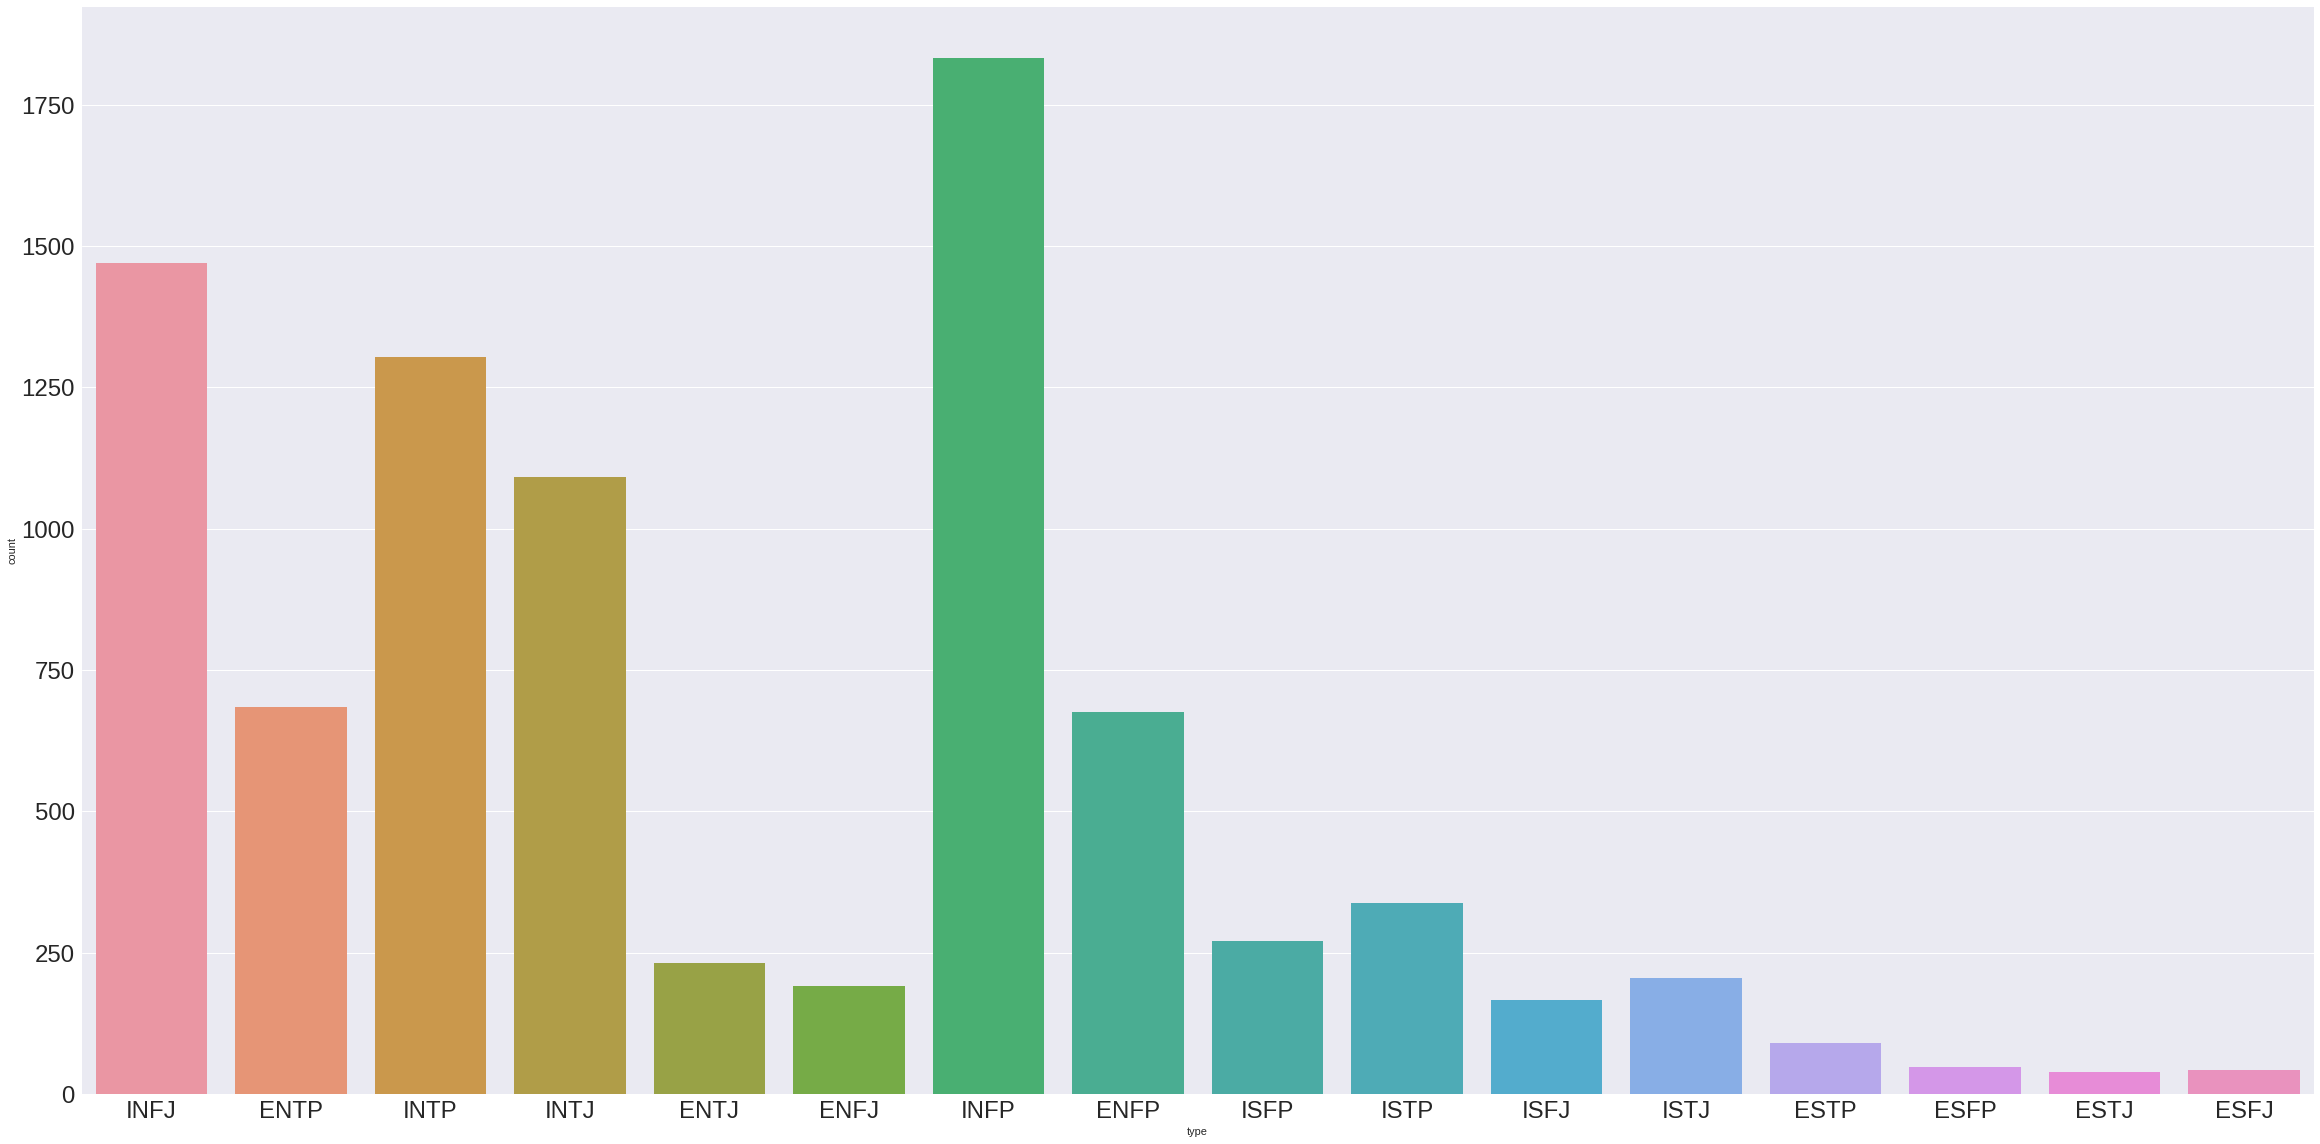

In [4]:
plt.figure(figsize=(40,20))
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
sns.countplot(data=data, x='type')

#### It is clearly unbalanced throughout the different classes. 

# Preprocessing

### Label Encoding

In [5]:
##### Encode each type to an int

from sklearn.preprocessing import LabelEncoder

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
lab_encoder = LabelEncoder().fit(unique_type_list)


### Posts cleaning

In [6]:
import time
##### Compute list of subject with Type | list of comments 

# Time
%time data.posts[1].replace('+', ' ').replace('.', ' ').replace(',', ' ').replace(':', ' ')
%time re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', data.posts[1])


from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Lemmatizer | Stemmatizer
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")

# One post
OnePost = data.posts[1]

# List all urls
urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', OnePost)

# Remove urls
temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'link', OnePost)

# Keep only words
temp = re.sub("[^a-zA-Z]", " ", temp)

# Remove spaces > 1
temp = re.sub(' +', ' ', temp).lower()

# Remove stopwords and lematize
%time stemmer.stem(" ".join([w for w in temp.split(' ') if w not in cachedStopWords]))

print("\nBefore preprocessing:\n\n", OnePost[0:500])
print("\nAfter preprocessing:\n\n", temp[0:500])
print("\nList of urls:")
urls

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 309 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 621 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.45 ms

Before preprocessing:

 'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + L

After preprocessing:

  i m finding the lack of me in these posts very alarming sex can be boring if it s in the same position often for example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary there isn t enough giving new 

['http://img188.imageshack.us/img188/6422/6020d1f9da6944a6b71bbe6.jpg',
 'http://img.adultdvdtalk.com/813a0c6243814cab84c51',
 'http://i817.photobucket.com/albums/zz96/kamioo/Dirtywinch.png',
 'http://i817.photobucket.com/albums/zz96/kamioo/Thunderstorm.pnghttp://i817.photobucket.com/albums/zz96/kamioo/Thunderstormbw.png',
 'http://i817.photobucket.com/albums/zz96/kamioo/Cosmicstorm.png',
 'http://www.youtube.com/watch?v=j5W73HaVQBg',
 'http://i817.photobucket.com/albums/zz96/kamioo/Deathgrip.png',
 'http://i817.photobucket.com/albums/zz96/kamioo/Deathgripbw.png',
 'http://i817.photobucket.com/albums/zz96/kamioo/Statickitten.png']

### Preprocessing comments

* Replace urls with a dummy word: "link"
* Keep only words and put everything lowercase
* Lemmatize each word 


In [7]:
##### Compute list of subject with Type | list of comments 
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def pre_process_data(data, remove_stop_words=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if i % 500 == 0:
            print("%s | %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'link', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

        type_labelized = lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)
        list_posts.append(temp)

    #del data
    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

list_posts, list_personality = pre_process_data(data, remove_stop_words=True)

500 | 8675 rows
1000 | 8675 rows
1500 | 8675 rows
2000 | 8675 rows
2500 | 8675 rows
3000 | 8675 rows
3500 | 8675 rows
4000 | 8675 rows
4500 | 8675 rows
5000 | 8675 rows
5500 | 8675 rows
6000 | 8675 rows
6500 | 8675 rows
7000 | 8675 rows
7500 | 8675 rows
8000 | 8675 rows
8500 | 8675 rows


### Vectorize with count and tf-idf

I kept the words appearing in 10 to 50% of the posts. 

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

cntizer = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
#                             ngram_range=(1,1),
                             max_df=0.5,
                             min_df=0.1) 
                                 
tfizer = TfidfTransformer()

print("CountVectorizer")
X_cnt = cntizer.fit_transform(list_posts)
print("Tf-idf")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()

CountVectorizer
Tf-idf


In [9]:
list_posts[0]

' link link enfp intj moment link sportscenter top ten play link prank life changing experience life link link repeat today may perc experience immerse last thing infj friend posted facebook committing suicide next day rest peace link hello enfj sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth link link welcome stuff link game set match prozac wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left thing moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear enfp favorite video game growing current favorite video game cool link appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjo

### Count the top 50 words of the count vectorizer

In [11]:

top_50 = np.asarray(np.argsort(np.sum(X_cnt, axis=0))[0,-50:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_50]

['infp',
 'infj',
 'intj',
 'intp',
 'relationship',
 'lol',
 'enfp',
 'yeah',
 'thanks',
 'oh',
 'bit',
 'may',
 'entp',
 'agree',
 'quite',
 'guess',
 'talk',
 'school',
 'great',
 'thank',
 'personality',
 'use',
 'function',
 'bad',
 'everything',
 'interesting',
 'believe',
 'definitely',
 'happy',
 'reason',
 'part',
 'used',
 'often',
 'seem',
 'experience',
 'last',
 'word',
 'anyone',
 'test',
 'keep',
 'hate',
 'another',
 'girl',
 'forum',
 'enough',
 'put',
 'else',
 'care',
 'talking',
 'getting']

The 4 top words are actually some mbti profiles... This is strange!

Lets try dimensionality reduction:

In [12]:
from sklearn.decomposition import TruncatedSVD
# Truncated SVD
svd = TruncatedSVD(n_components=12, n_iter=7, random_state=42)
svd_vec = svd.fit_transform(X_tfidf)

print("TSNE")
X_tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=650).fit_transform(svd_vec)

TSNE
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8675 samples in 0.013s...
[t-SNE] Computed neighbors for 8675 samples in 2.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8675
[t-SNE] Computed conditional probabilities for sample 2000 / 8675
[t-SNE] Computed conditional probabilities for sample 3000 / 8675
[t-SNE] Computed conditional probabilities for sample 4000 / 8675
[t-SNE] Computed conditional probabilities for sample 5000 / 8675
[t-SNE] Computed conditional probabilities for sample 6000 / 8675
[t-SNE] Computed conditional probabilities for sample 7000 / 8675
[t-SNE] Computed conditional probabilities for sample 8000 / 8675
[t-SNE] Computed conditional probabilities for sample 8675 / 8675
[t-SNE] Mean sigma: 0.065712
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.703964
[t-SNE] Error after 650 iterations: 1.932286


### Plot tsne with 3 components

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


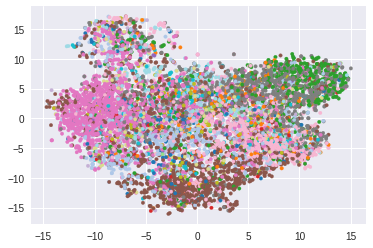

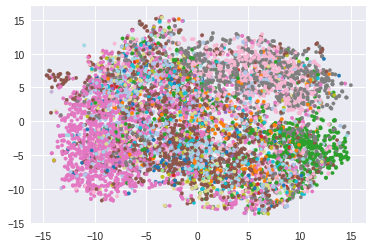

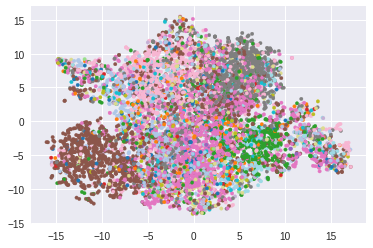

In [13]:
col = list_personality
plt.figure(0)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.figure(1)
plt.scatter(X_tsne[:,0], X_tsne[:,2], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.figure(2)
plt.scatter(X_tsne[:,1], X_tsne[:,2], c=col, cmap=plt.get_cmap('tab20') , s=12)
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Plot first axes of decomposition

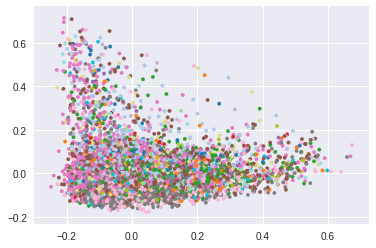

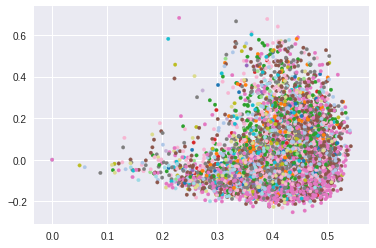

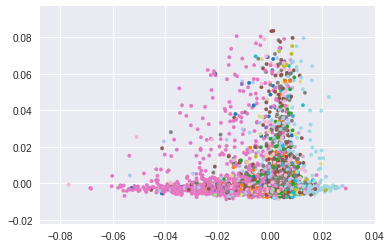

In [14]:
from sklearn.decomposition import KernelPCA, FastICA, PCA
from sklearn.preprocessing import StandardScaler

# PCA
pca_vec = PCA(n_components=12).fit_transform(X_tfidf)

# ICA
ica_vec = FastICA(n_components=12).fit_transform(X_tfidf)

# Plot
plt.figure(1)
plt.scatter(pca_vec[:,0], pca_vec[:,1], c=list_personality, cmap=plt.get_cmap('tab20'), s=12)
plt.figure(2)
plt.scatter(svd_vec[:,0], svd_vec[:,1], c=list_personality, cmap=plt.get_cmap('tab20'), s=12)
plt.figure(3)
plt.scatter(ica_vec[:,0], ica_vec[:,1], c=list_personality, cmap=plt.get_cmap('tab20'), s=12)

#### Plot tsne for each pair of letter:

* Extraversion (E) - Introversion (I)
* Sensation (S) - INtuition (N)
* Thinking (T) - Feeling (F)
* Judgement (J) - Perception (P)

In [15]:
# Split mbti personality into 4 letters and binarize
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    '''
    transform mbti to binary vector
    '''
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    '''
    transform binary vector to mbti personality
    '''
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

# Plot
def plot_tsne(X, i):
    a = plt.figure(i, figsize=(30,20))
    plt.title(titles[i])
    plt.subplot(3,1,1)
    plt.scatter(X[:,0], X[:,1], c=list_personality_bin[:,i], cmap=plt.get_cmap('Dark2'), s=25)
    plt.subplot(3,1,2)
    plt.scatter(X[:,0], X[:,2], c=list_personality_bin[:,i], cmap=plt.get_cmap('Dark2'), s=25)
    plt.subplot(3,1,3)
    plt.scatter(X[:,1], X[:,2], c=list_personality_bin[:,i], cmap=plt.get_cmap('Dark2'), s=25)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ..., 
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


#### Extraversion (E) - Introversion (I)

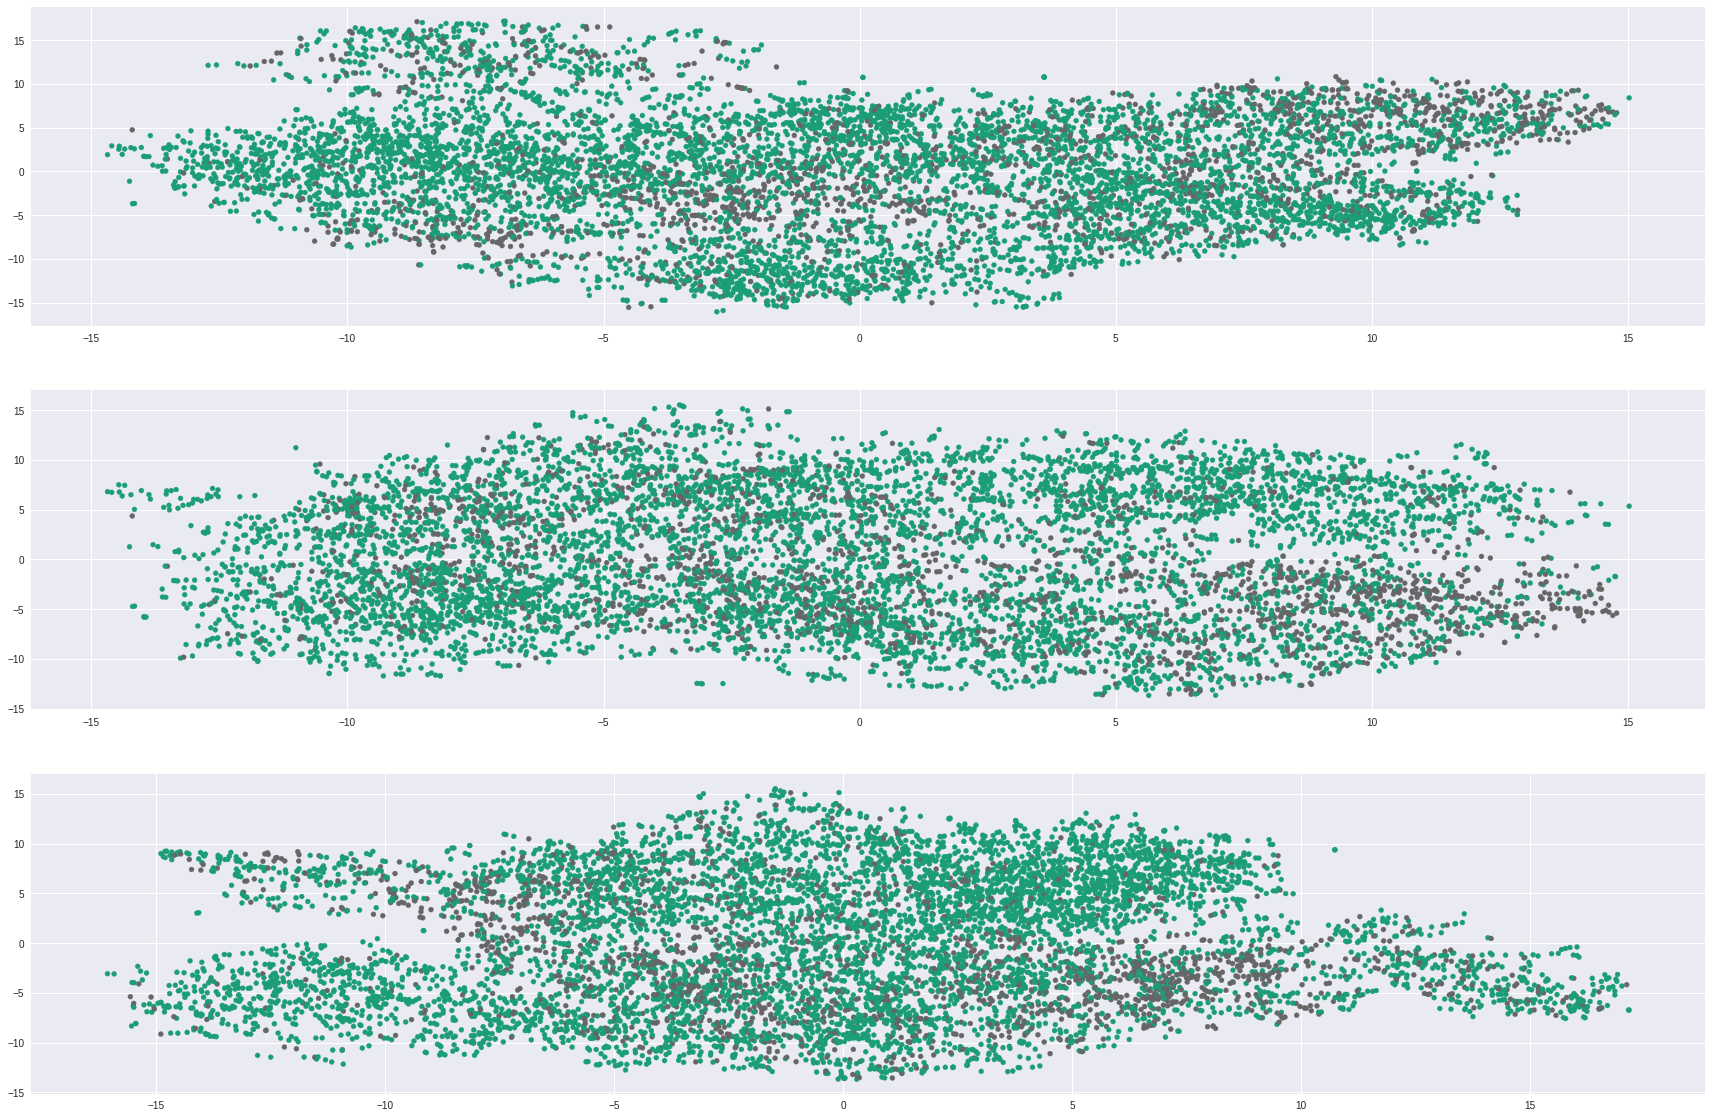

In [16]:
plot_tsne(X_tsne, 0)

#### Sensation (S) - INtuition (N)

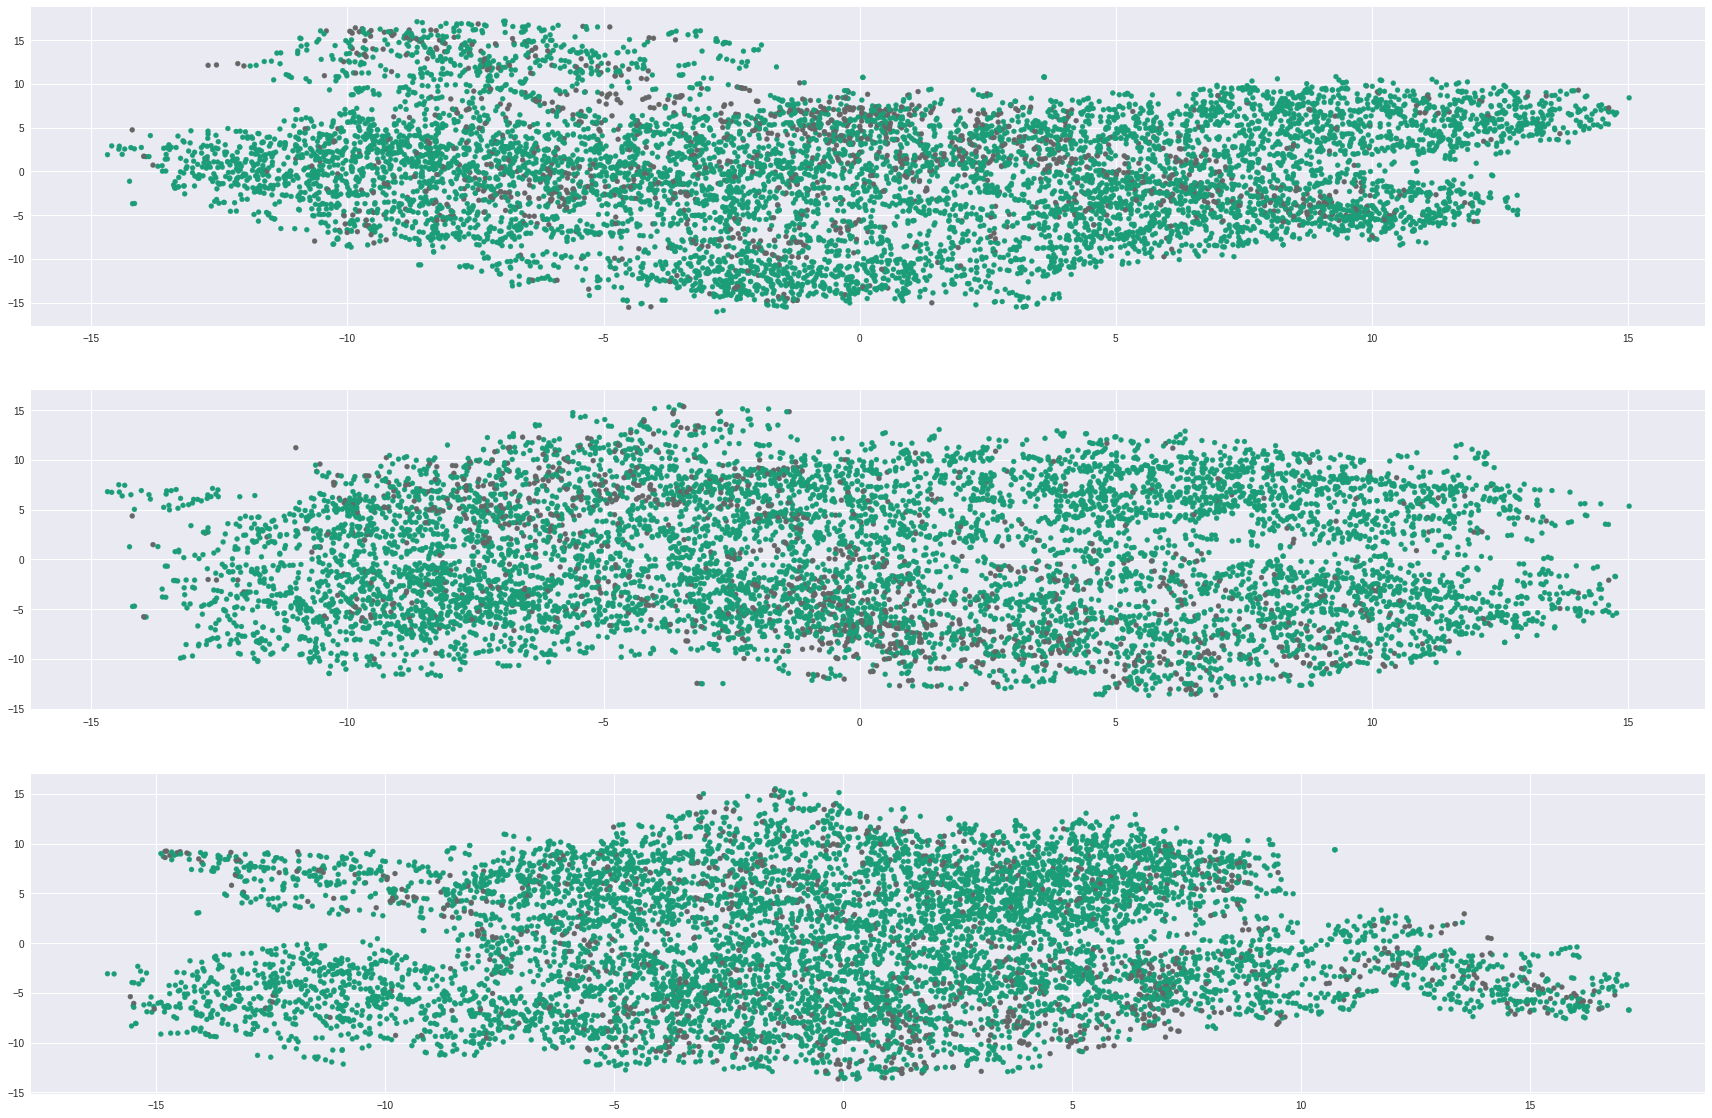

In [17]:
plot_tsne(X_tsne, 1)

#### Thinking (T) - Feeling (F)

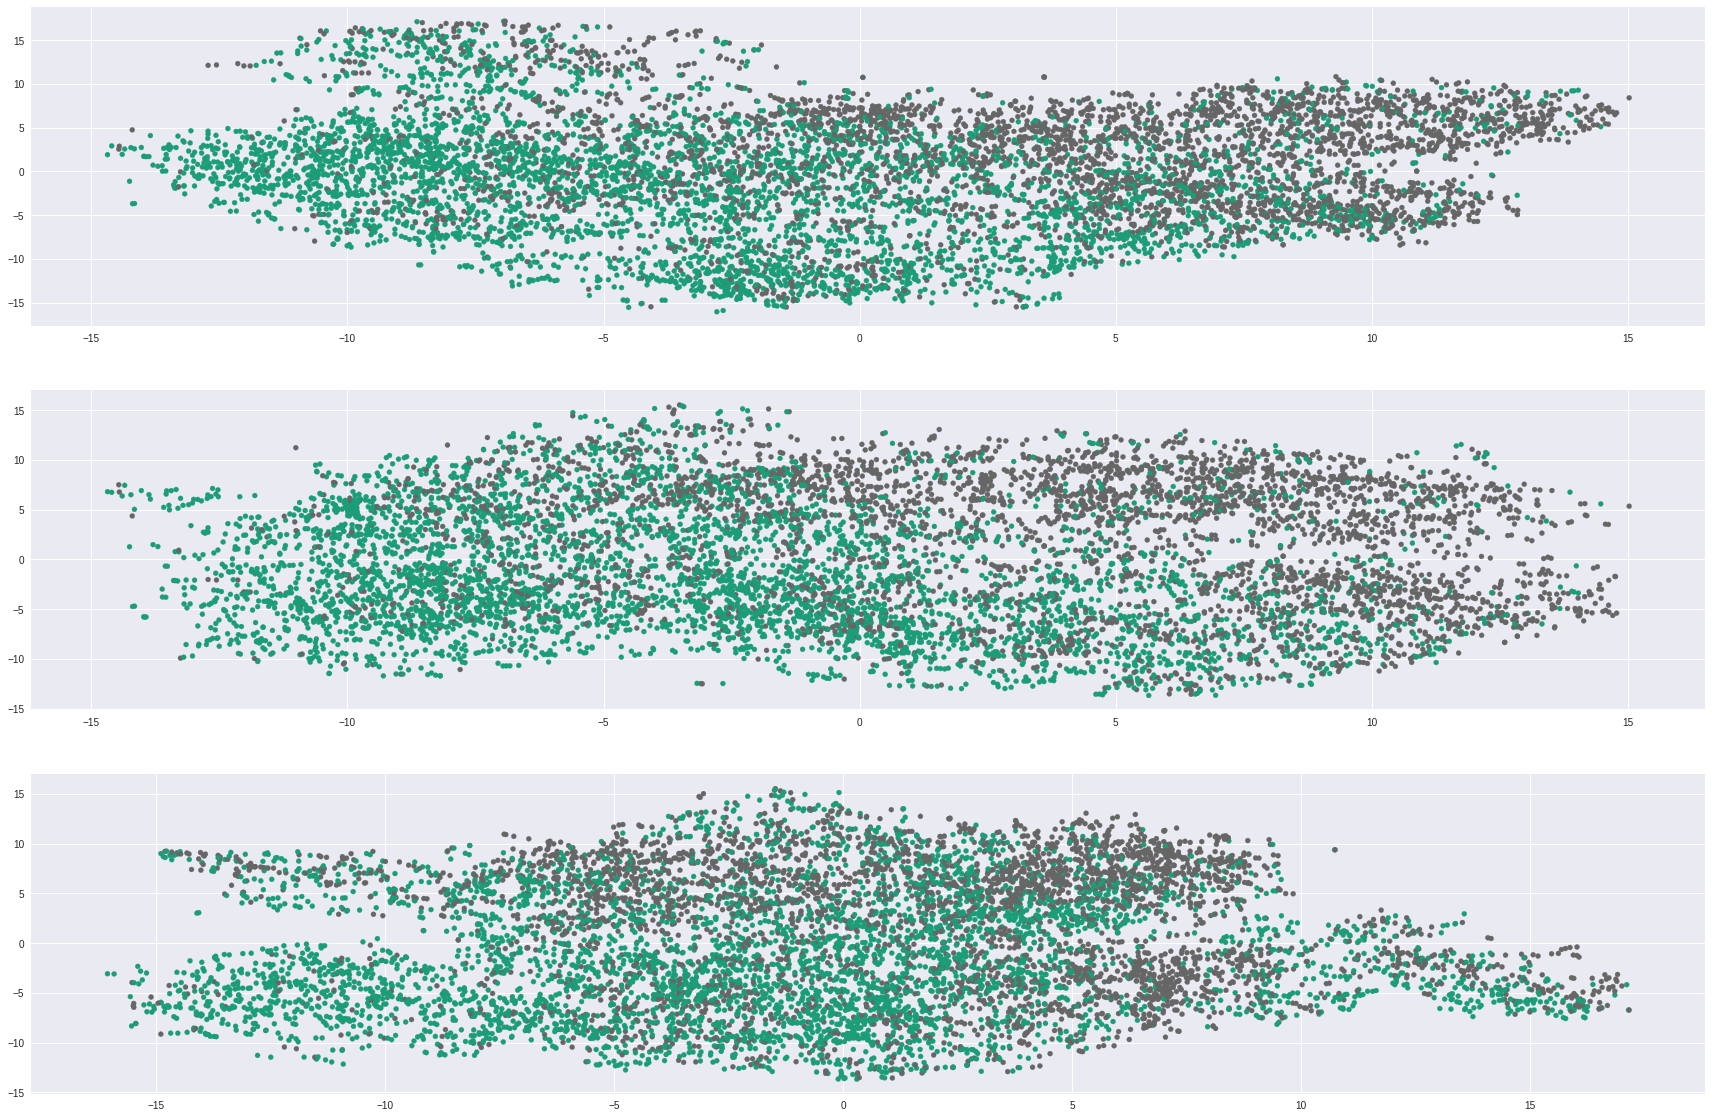

In [18]:
plot_tsne(X_tsne, 2)

#### Judgement (J) - Perception (P)

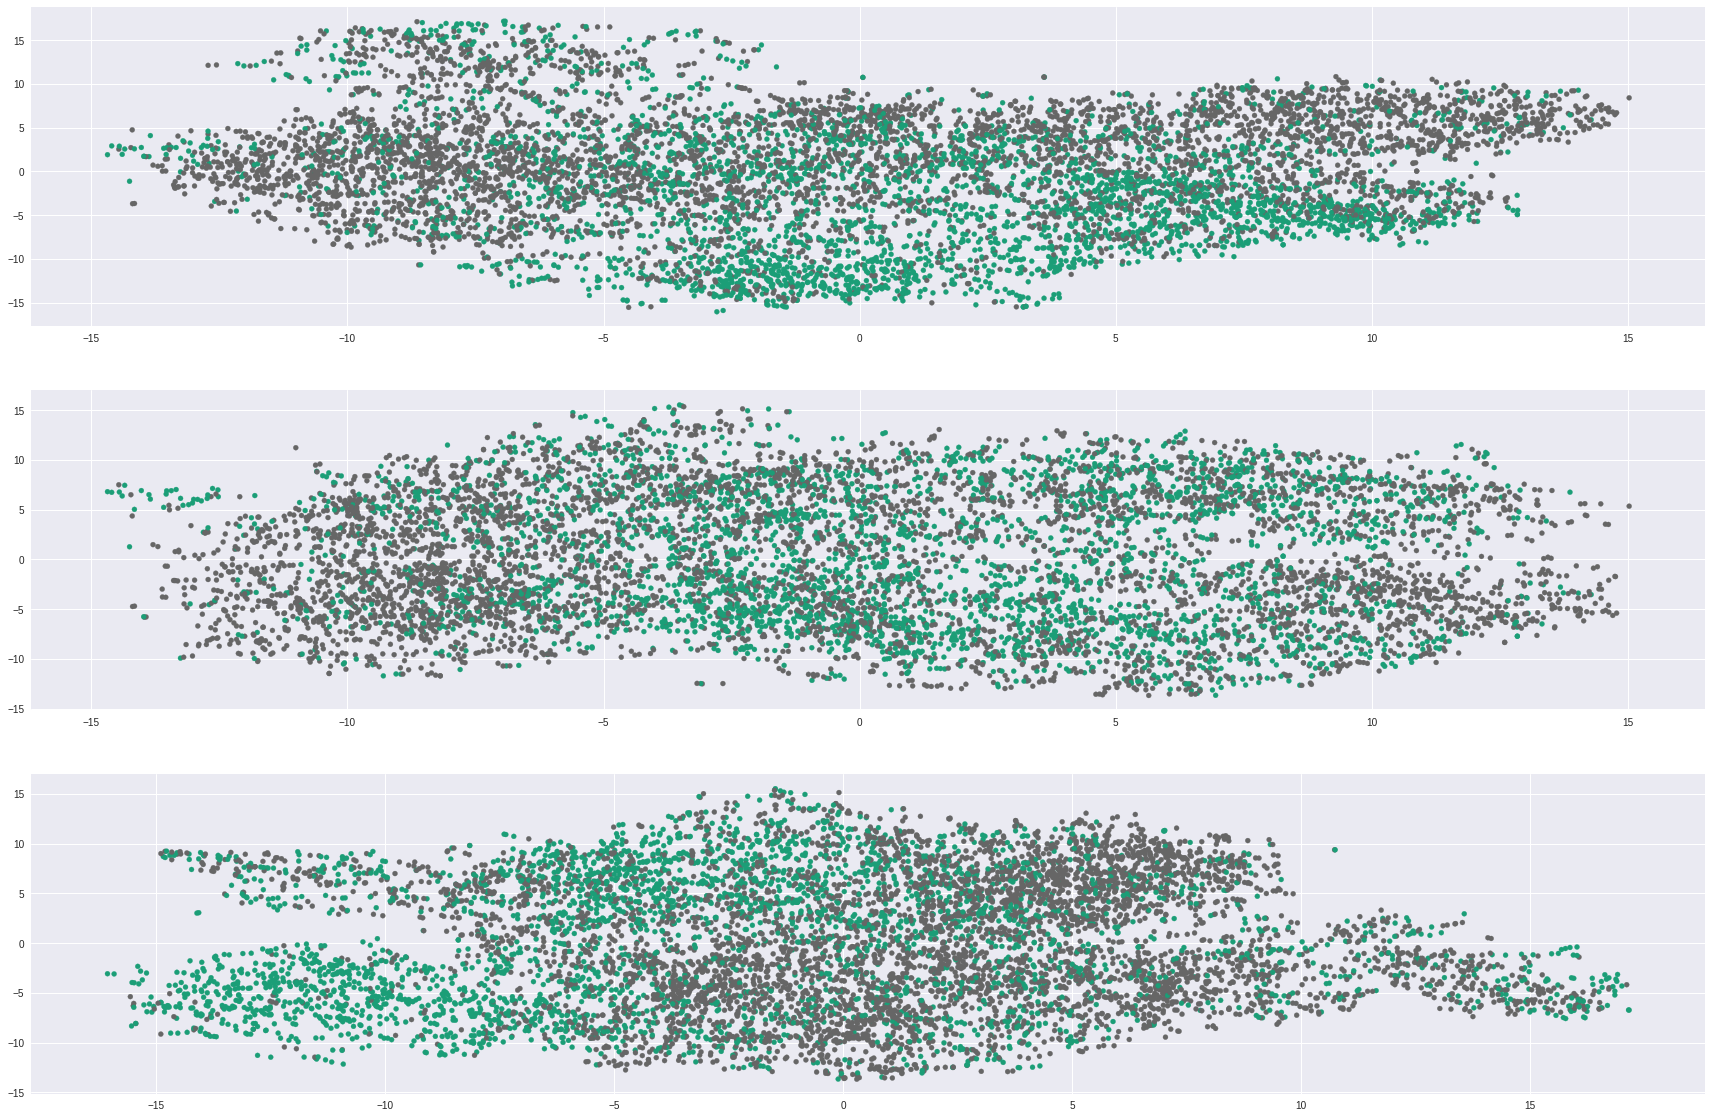

In [19]:
plot_tsne(X_tsne, 3)

#### Confusion plot function

In [20]:
# Confusion plot
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Try multiple sklearn classifiers

In [21]:
##### Sklearn classifiers

from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

import xgboost as xgb
import pickle

# Vectorizer

cntizer = CountVectorizer(analyzer="word", 
                             max_features=1000, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,   
                             max_df=0.5,
                             min_df=0.1) 

tfizer = TfidfTransformer()

# Classifiers
PassAgg = PassiveAggressiveClassifier(max_iter=50)

sgd = SGDClassifier(loss='hinge',   
              penalty='l1',   
              alpha=1e-2,     
              random_state=42,
              max_iter=7,     
              tol=None)

# SVM
lsvc = LinearSVC()

# Multinomial Naive Bayes
mlNB = MultinomialNB()

# Xgboost 
# setup parameters for xgboost
param = {}

# use softmax multi-class classification
param['objective'] = 'multi:softprob'
# scale weight of positive examples
param['eta'] = 0.6
param['ntrees'] = 300
param['subsample'] = 0.93
param['max_depth'] = 2
param['silent'] = 1
param['n_jobs'] = 8
param['num_class'] = len(unique_type_list)
xgb_class = xgb.XGBClassifier(**param)

### Stratified K-fold validation training

In [22]:
# Train with k fold stratified validation

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

name = lambda x : str(x).split('(')[0]

def train_stratified(models, X, y, add_idf=False, nsplits=3, confusion=False):
    '''
    Take a sklearn model like, feature set X, target set y and number of splits to compute Stratified kfold validation.
    Args:
        X (array):       Numpy array of features.
        y (str):         Target - Personality list.
        add_idf (bool):  Wehther to use tf-idf on CountVectorizer.
        nsplits(int):    Number of splits for cross validation.
        confusion(bool): Wether to plot confusion matrix 
        
    Returns:
        dict: Dictionnary of classifiers and their cv f1-score.
    '''
    fig_i = 0
    kf = StratifiedShuffleSplit(n_splits=nsplits)
    
    # Store fold score for each classifier in a dictionnary
    dico_score = {}
    dico_score['merged'] = 0
    for model in models:
        dico_score[name(model)] = 0
    
    # Stratified Split
    for train, test in kf.split(X,y):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        
        X_train = cntizer.fit_transform(X_train)
        X_test = cntizer.transform(X_test)
        
        # tf-idf
        if add_idf == True:
            X_train_tfidf = tfizer.fit_transform(X_train_cnt)
            X_test_tfidf = tfizer.transform(X_test_cnt)
        
            X_train = np.column_stack((X_train_tfidf.todense(), X_train))
            X_test = np.column_stack((X_test_tfidf.todense(), X_test))
        
        probs = np.ones((len(y_test), 16))
        for model in models:
            # if xgboost use dmatrix
            if 'XGB' in name(model):
                xg_train = xgb.DMatrix(X_train, label=y_train)
                xg_test = xgb.DMatrix(X_test, label=y_test)
                watchlist = [(xg_train, 'train'), (xg_test, 'test')]
                num_round = 30
                bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=6)
                preds = bst.predict(xg_test)
                probs = np.multiply(probs, preds)
                preds = np.array([np.argmax(prob) for prob in preds])
            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                probs = np.multiply(probs, model.predict_proba(X_test))
            # f1-score
            score = f1_score(y_test, preds, average='weighted')
            dico_score[name(model)] += score
            print('%s : %s' % (str(model).split('(')[0], score))
            
            if confusion == True:
                # Compute confusion matrix
                cnf_matrix = confusion_matrix(y_test, preds)
                np.set_printoptions(precision=2)
                # Plot confusion matrix
                plt.figure(fig_i)
                fig_i += 1
                plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(16)), normalize=True,
                                                          title=('Confusion matrix %s' % name(model)))
        
        # product of class probabilites of each classifier 
        merged_preds = [np.argmax(prob) for prob in probs]
        score = f1_score(y_test, merged_preds, average='weighted')
        print('Merged score: %s' % score)
        dico_score['merged'] += score
        
    return {k: v / nsplits for k, v in dico_score.items()}



#### Compare multinomial naive bayes, xgb and their product predictions

MultinomialNB : 0.599967118315
Confusion matrix
[0]	train-merror:0.40041	test-merror:0.417051
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.375432	test-merror:0.398618
[2]	train-merror:0.363776	test-merror:0.382488
[3]	train-merror:0.35481	test-merror:0.37212
[4]	train-merror:0.341873	test-merror:0.366359
[5]	train-merror:0.338799	test-merror:0.364055
[6]	train-merror:0.331754	test-merror:0.355991
[7]	train-merror:0.325093	test-merror:0.357143
[8]	train-merror:0.317151	test-merror:0.355991
[9]	train-merror:0.313437	test-merror:0.353687
[10]	train-merror:0.305623	test-merror:0.346774
[11]	train-merror:0.298834	test-merror:0.347926
[12]	train-merror:0.295376	test-merror:0.342166
[13]	train-merror:0.289484	test-merror:0.33871
[14]	train-merror:0.284104	test-merror:0.33871
[15]	train-merror:0.279365	test-merror:0.339862
[16]	train-merror:0.276291	test-merror:0.334101
[17]	

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Merged score: 0.628842195265
MultinomialNB : 0.58312071295
Confusion matrix
[0]	train-merror:0.414372	test-merror:0.426267
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.386576	test-merror:0.391705
[2]	train-merror:0.368772	test-merror:0.387097
[3]	train-merror:0.361342	test-merror:0.384793
[4]	train-merror:0.354938	test-merror:0.375576
[5]	train-merror:0.3461	test-merror:0.364055
[6]	train-merror:0.34136	test-merror:0.355991
[7]	train-merror:0.332266	test-merror:0.358295
[8]	train-merror:0.32727	test-merror:0.358295
[9]	train-merror:0.31856	test-merror:0.342166
[10]	train-merror:0.312796	test-merror:0.347926
[11]	train-merror:0.306648	test-merror:0.351382
[12]	train-merror:0.299603	test-merror:0.34447
[13]	train-merror:0.297425	test-merror:0.33871
[14]	train-merror:0.290765	test-merror:0.341014
[15]	train-merror:0.285513	test-merror:0.34447
[16]	train-merror:0.281798	t

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Merged score: 0.621073959444
MultinomialNB : 0.613574928547
Confusion matrix
[0]	train-merror:0.425003	test-merror:0.408986
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.389906	test-merror:0.370968
[2]	train-merror:0.373639	test-merror:0.353687
[3]	train-merror:0.361983	test-merror:0.343318
[4]	train-merror:0.354041	test-merror:0.331797
[5]	train-merror:0.3461	test-merror:0.331797
[6]	train-merror:0.340464	test-merror:0.326037
[7]	train-merror:0.326374	test-merror:0.321429
[8]	train-merror:0.320097	test-merror:0.308756
[9]	train-merror:0.313309	test-merror:0.317972
[10]	train-merror:0.306392	test-merror:0.320276
[11]	train-merror:0.302421	test-merror:0.321429
[12]	train-merror:0.296785	test-merror:0.315668
[13]	train-merror:0.29307	test-merror:0.320276
[14]	train-merror:0.290252	test-merror:0.321429
Stopping. Best iteration:
[8]	train-merror:0.320097	test-merror:0.3087

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


MultinomialNB : 0.599695557106
Confusion matrix
[0]	train-merror:0.412322	test-merror:0.402074
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.381068	test-merror:0.390553
[2]	train-merror:0.365697	test-merror:0.37788
[3]	train-merror:0.353273	test-merror:0.368664
[4]	train-merror:0.344563	test-merror:0.362903
[5]	train-merror:0.337774	test-merror:0.352535
[6]	train-merror:0.333931	test-merror:0.35023
[7]	train-merror:0.327398	test-merror:0.349078
[8]	train-merror:0.321634	test-merror:0.351382
[9]	train-merror:0.316511	test-merror:0.347926
[10]	train-merror:0.308569	test-merror:0.354839
[11]	train-merror:0.303446	test-merror:0.353687
[12]	train-merror:0.295888	test-merror:0.352535
[13]	train-merror:0.290509	test-merror:0.358295
[14]	train-merror:0.286153	test-merror:0.354839
[15]	train-merror:0.282183	test-merror:0.351382
Stopping. Best iteration:
[9]	train-merror:0.31651

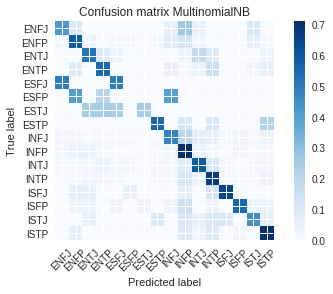

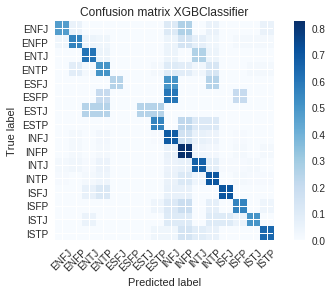

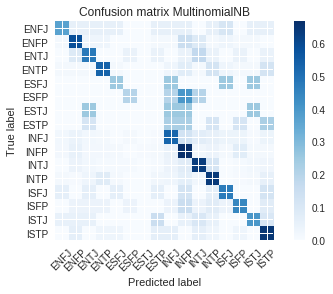

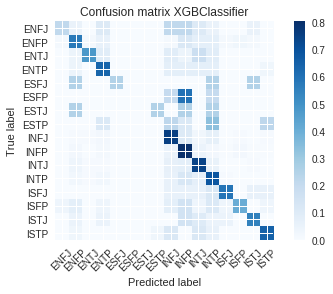

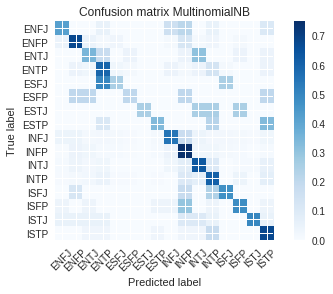

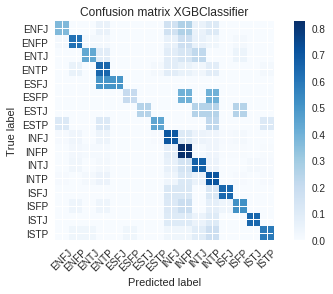

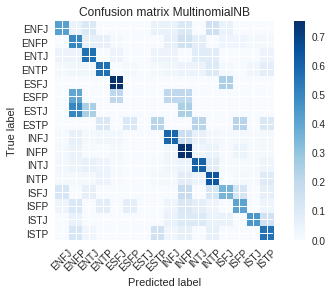

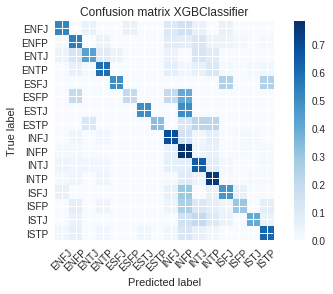

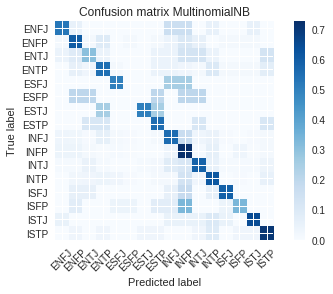

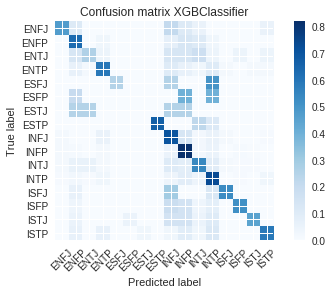

In [23]:
results = train_stratified([mlNB, xgb_class], list_posts, list_personality, add_idf=False, nsplits=5, confusion=True)

In [24]:
results

{'MultinomialNB': 0.59990096683720195,
 'XGBClassifier': 0.65537645464049599,
 'merged': 0.63455003168668456}

### Try multioutput classification

In [25]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    '''
    transform mbti to binary vector
    '''
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    '''
    transform binary vector to mbti personality
    '''
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)


Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ..., 
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [26]:
# Feed classifier to MultiOutputCLassifier

clf = AdaBoostClassifier()
multi_target_classifier = MultiOutputClassifier(clf, n_jobs=-1)
multi_target_classifier.fit(X_tfidf, list_personality_bin)
preds = multi_target_classifier.predict(X_tfidf)

preds_t = [translate_back(p) for p in preds]
vec1 = data.type ==  preds_t
for i in range(4):
    print("f1 score for %s:\n%s" % (titles[i],
                                    f1_score(np.array(list_personality_bin)[:,i], preds[:,i])))


f1 score for Extraversion (E) - Introversion (I):
0.646118057575
f1 score for Sensation (S) - INtuition (N):
0.568921011874
f1 score for Thinking (T) - Feeling (F):
0.819064430715
f1 score for Judgement (J) - Perception (P):
0.846238130022


In [27]:
# Stratified cross val for multi-output
X = list_posts
y = np.array(list_personality_bin)

clf = AdaBoostClassifier()

kf = StratifiedShuffleSplit(n_splits=4)

list_score = []
list_score_per_class= []

for train, test in kf.split(X, y):
    X_train, X_test, y_train, y_test = \
        X[train], X[test], y[train], y[test]

    X_train = cntizer.fit_transform(X_train)
    X_test = cntizer.transform(X_test)
    
    X_train = tfizer.fit_transform(X_train).toarray()
    X_test = tfizer.transform(X_test).toarray()

    multi_target_classifier = MultiOutputClassifier(clf, n_jobs=-1)
    multi_target_classifier.fit(X_train, y_train)
    preds = multi_target_classifier.predict(X_test)
    
    rev_preds = np.array([translate_back(p) for p in preds]) 
    rev_test = np.array([translate_back(p) for p in y_test])
    score = f1_score(rev_test,rev_preds, average='weighted')
    list_score.append(score)
    print('\nTotal score: %s' % f1_score(rev_test,rev_preds, average='weighted'))

    list_temp =[]
    for i in range(4):
        score_per_class = f1_score(y_test[:,i], preds[:,i])
        list_temp.append(score_per_class)
        print(score_per_class)
    list_score_per_class.append(list_temp)



Total score: 0.509371839569
0.568965517241
0.47619047619
0.791563275434
0.828597616865

Total score: 0.519350963469
0.59649122807
0.445652173913
0.78381795196
0.840215439856

Total score: 0.52311795188
0.599423631124
0.449438202247
0.791979949875
0.833634719711

Total score: 0.504133809895
0.622950819672
0.497461928934
0.790816326531
0.800734618916


In [28]:
list_score_per_class = np.array(list_score_per_class)
print('Mean score per classes: %s' % list_score_per_class.mean(axis=0))

Mean score per classes: [ 0.6   0.47  0.79  0.83]


## Neural Nets 

### 1D convolutional with glove embedding

In [29]:
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model

mbti_1 = pd.read_csv('data/mbti_1.csv') 
posts = mbti_1.posts

BASE_DIR = ''
GLOVE_DIR = "data/glove.6B"
TEXT_DATA_DIR = "data/20_newsgroup"
MAX_SEQUENCE_LENGTH = 923
MAX_NB_WORDS = 2000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_a

FileNotFoundError: File b'data/mbti_1.csv' does not exist

In [30]:
# build index mapping words in the embeddings set to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.%sd.txt'%str(EMBEDDING_DIM)))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.


NameError: name 'GLOVE_DIR' is not defined

In [31]:
# prepare text samples and their labels
print('Processing text dataset')

texts = [post.replace("link", "") for post in list_posts] # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = np.array(list_personality_bin)
# list of label ids


print('Found %s texts.' % len(texts))


Processing text dataset
Found 8675 texts.


In [32]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


NameError: name 'MAX_NB_WORDS' is not defined

In [33]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]


KeyError: '[ 784 8652 3596 ..., 7170 7763 3809] not in index'

In [34]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix.


NameError: name 'MAX_NB_WORDS' is not defined

### Define network

In [35]:
print('Training convolutional network.')

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(64, 4, activation='relu')(embedded_sequences)
x = MaxPooling1D(4)(x)
x = Conv1D(64, 4, activation='relu')(x)
x = MaxPooling1D(4)(x)
x = Conv1D(64, 4, activation='relu')(x)
x = MaxPooling1D(25)(x)  # global max pooling
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(4, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


Training convolutional network.


NameError: name 'MAX_SEQUENCE_LENGTH' is not defined

In [36]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

NameError: name 'model' is not defined

In [37]:
# Summer is coming!
print('Training convolutional network.')

model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=100, batch_size=256)

Training convolutional network.


NameError: name 'model' is not defined

### Bidirectional LSTM

In [38]:
# Bidirectional LSTM

import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

VALIDATION_SPLIT = 0.2
MAX_NB_WORDS = 20000

# fix random seed for reproducibility
numpy.random.seed(7)

# Tokenize
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(list_posts)
sequences = tokenizer.texts_to_sequences(list_posts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88838 unique tokens.


In [39]:
# split the data into a training set and a validation set

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_test = train_test_split(sequences, list_personality_bin, test_size=0.3, random_state=0, stratify=list_personality)

# truncate and pad input sequences
max_sentence_length = 600
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_val, maxlen=max_review_length)

max_features = 2000
batch_size = 32

print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)


model = Sequential()
model.add(Embedding(max_features, 256, input_length=max_review_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(4, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[X_test, y_test])

NameError: name 'max_review_length' is not defined